## Analysis of the simpler Nuclear Shell model Hamiltonian

#### Imports

In [1]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize,dual_annealing
from tqdm import trange
from src.qml_utils.utils import Schedule,SchedulerModel
from scipy.sparse import csr_matrix, diags
from numpy.linalg import eigh

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters of the model

In [2]:
nlevels=3

tf=50
nsteps=30
number_of_parameters=5

file_name:str='data/usdb.nat'
qq_filename:str='data/qq.sd'
pairing_filename:str='data/pair_inter.sd'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=2
nparticles_b:int=2

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{8}$Be'

#### The target Hamiltonian

In [14]:
# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
print(J2pshell.j_value(psis[:,0]))
egs=egs[0]
print(egs)
psi0=psis[:,:1]

size= 24 12
Hamiltonian shape= (640, 640)
()
7.327471962526033e-15
-41.396490072569996


#### Mean field Hamiltonian

In [4]:
from scipy.sparse import lil_matrix
external_potential=lil_matrix((TargetHamiltonian.basis.shape[0],TargetHamiltonian.basis.shape[0]))

for i,b in enumerate(TargetHamiltonian.basis):
    psi_slater=np.zeros(TargetHamiltonian.basis.shape[0])
    psi_slater[i]=1.
    external_potential[i,i]=(psi_slater.dot(TargetHamiltonian.hamiltonian.dot(psi_slater)))
    
MeanFieldHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
MeanFieldHamiltonian.get_external_potential(energies)
MeanFieldHamiltonian.get_hamiltonian()

print(MeanFieldHamiltonian.hamiltonian)


  (0, 0)	-15.7028
  (1, 1)	-9.665400000000002
  (2, 2)	-15.7028
  (3, 3)	-9.665400000000002
  (4, 4)	-14.985000000000001
  (5, 5)	-9.665400000000002
  (6, 6)	-15.7028
  (7, 7)	-15.7028
  (8, 8)	-9.665400000000002
  (9, 9)	-14.985000000000001
  (10, 10)	-9.665400000000002
  (11, 11)	-14.985000000000001
  (12, 12)	-9.665400000000002
  (13, 13)	-8.947600000000001
  (14, 14)	-3.628
  (15, 15)	-15.7028
  (16, 16)	-15.7028
  (17, 17)	-9.665400000000002
  (18, 18)	-14.985000000000001
  (19, 19)	-9.665400000000002
  (20, 20)	-14.985000000000001
  (21, 21)	-9.665400000000002
  (22, 22)	-9.665400000000002
  (23, 23)	-8.947600000000001
  (24, 24)	-8.947600000000001
  :	:
  (615, 615)	-2.1924
  (616, 616)	3.1271999999999998
  (617, 617)	3.1271999999999998
  (618, 618)	8.4468
  (619, 619)	8.4468
  (620, 620)	-3.628
  (621, 621)	2.4093999999999998
  (622, 622)	-3.628
  (623, 623)	-2.9102
  (624, 624)	2.4093999999999998
  (625, 625)	-2.9102
  (626, 626)	2.4093999999999998
  (627, 627)	2.4093999999999

#### What if we get an effective two-body matrix?

In [4]:
v_ab=np.zeros((energies.shape[0],energies.shape[0]))
v_dict={}
for a in trange(energies.shape[0]):
    for b in trange(energies.shape[0]):
        
        if a >= energies.shape[0]//2 and b <= energies.shape[0]//2:
            continue
        elif a <= energies.shape[0]//2 and b>= energies.shape[0]//2:
            continue
        else:
            for c in range(energies.shape[0]):
                for d in range(energies.shape[0]):
                    
                    if (a,c,b,d) in twobody_matrix.keys() or (a,c,d,b) in twobody_matrix.keys() or (c,a,b,d) in twobody_matrix.keys() or (c,a,d,b) in twobody_matrix.keys() :
                        v_ab[a,b]+=twobody_matrix[(a,c,b,d)]
                    else:
                        continue
            
        v_dict[(a,b)]=v_ab[a,b]/energies.shape[0]
        
v_ab=v_ab/energies.shape[0]

print(v_dict)
        

100%|██████████| 12/12 [00:00<00:00, 231.52it/s]

{(0, 0): -1.4633757998632582, (0, 1): -0.09660145721802471, (0, 2): -0.2832820833333332, (0, 3): 0.06594541666666665, (0, 4): -0.8068752567765719, (0, 5): -0.28061218430908946, (1, 0): -0.09660145721802464, (1, 1): -1.8647926277321973, (1, 2): -0.33333646540864853, (1, 3): -0.2832820833333333, (1, 4): 0.45199443871345474, (1, 5): -0.8069570678639003, (2, 0): -0.2832820833333332, (2, 1): -0.3333364654086484, (2, 2): -2.2662094556011367, (2, 3): -0.46308421574481295, (2, 4): -0.17658709687072457, (2, 5): 0.4519944387134546, (3, 0): 0.06594541666666665, (3, 1): -0.2832820833333333, (3, 2): -0.46308421574481295, (3, 3): -2.6676262834700757, (3, 4): 0.7206373320840932, (3, 5): 0.28495756054932747, (4, 0): -0.8068752567765722, (4, 1): 0.4519944387134547, (4, 2): -0.1765870968707246, (4, 3): 0.7206373320840931, (4, 4): -1.368869976764721, (4, 5): -0.43039629088752207, (5, 0): -0.2806121843090894, (5, 1): -0.8069570678639001, (5, 2): 0.45199443871345485, (5, 3): 0.2849575605493275, (5, 4): -0.

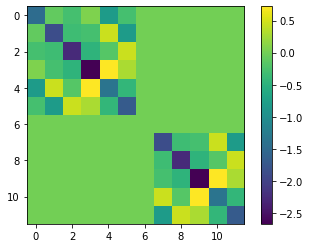

In [5]:
plt.imshow(v_ab)
plt.colorbar()
plt.show()

We define an Hamiltonian with this effective term

In [19]:
# Target Hamiltonian
EffectiveHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    EffectiveHamiltonian.get_kinetic_operator(adj_matrix=v_dict)
else:
    EffectiveHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
EffectiveHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

EffectiveHamiltonian.get_hamiltonian()

eigenvalues,eigenstates=np.linalg.eigh(EffectiveHamiltonian.hamiltonian.todense())

print(egs)



Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.77it/s]


value= -1.4633757998632582 i,j= 0 0
value= -0.09660145721802471 i,j= 0 1
value= -0.2832820833333332 i,j= 0 2
value= 0.06594541666666665 i,j= 0 3
value= -0.8068752567765719 i,j= 0 4
value= -0.28061218430908946 i,j= 0 5
value= -0.09660145721802464 i,j= 1 0
value= -1.8647926277321973 i,j= 1 1
value= -0.33333646540864853 i,j= 1 2
value= -0.2832820833333333 i,j= 1 3
value= 0.45199443871345474 i,j= 1 4
value= -0.8069570678639003 i,j= 1 5
value= -0.2832820833333332 i,j= 2 0
value= -0.3333364654086484 i,j= 2 1
value= -2.2662094556011367 i,j= 2 2
value= -0.46308421574481295 i,j= 2 3
value= -0.17658709687072457 i,j= 2 4
value= 0.4519944387134546 i,j= 2 5
value= 0.06594541666666665 i,j= 3 0
value= -0.2832820833333333 i,j= 3 1
value= -0.46308421574481295 i,j= 3 2
value= -2.6676262834700757 i,j= 3 3
value= 0.7206373320840932 i,j= 3 4
value= 0.28495756054932747 i,j= 3 5
value= -0.8068752567765722 i,j= 4 0
value= 0.4519944387134547 i,j= 4 1
value= -0.1765870968707246 i,j= 4 2
value= 0.720637332084093

(225, 1)
(225, 225)
[-4.99880886 -4.82870643 -4.77817194 -4.60806951 -4.08087659 -4.01415862
 -3.86023967 -3.82518025 -3.79352169 -3.65507782 -3.53057189 -3.36046946
 -3.26632878 -3.09622635 -3.04569186 -2.95831491 -2.90724798 -2.87558943
 -2.84053001 -2.73767799 -2.63821402 -2.61263962 -2.5775802  -2.54592165
 -2.51618275 -2.46811159 -2.40747778 -2.35694328 -2.34608032 -2.27039229
 -2.18684085 -2.1437671  -2.09270017 -2.04975536 -1.97366467 -1.92313018
 -1.92259774 -1.79809181 -1.78468631 -1.75302775 -1.72028175 -1.68522234
 -1.65964794 -1.65356378 -1.62798938 -1.59825048 -1.59292996 -1.56319107
 -1.53153251 -1.51511991 -1.49007794 -1.46458542 -1.45584448 -1.43901101
 -1.39308864 -1.37229304 -1.34255415 -1.29448299 -1.28574205 -1.23520755
 -1.22583483 -1.17245172 -1.09676368 -1.06510512 -1.00519791 -0.97013849
 -0.90573394 -0.84510012 -0.80215532 -0.80003606 -0.78370267 -0.76729007
 -0.73563151 -0.7005721  -0.67553013 -0.67499769 -0.6452588  -0.6244632
 -0.61360024 -0.59772008 -0.5785

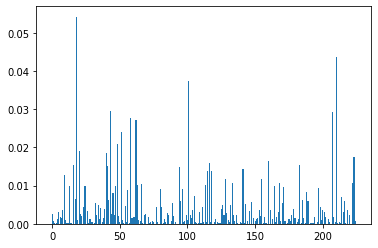

In [20]:
print(psi0.shape)
print(eigenstates.shape)

overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.show()

#### Define the simpler Hamiltonian

Hyperparameters

In [5]:
pairing_coupling=+1
quadrupole_coupling=+1

In [6]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)

Qoperator=QuadrupoleOperator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero],single_particle_basis=SPS.state_encoding,operator_symmetries=[SPS.projection_conservation])

quad_operator=Qoperator.quadrupole_operator[0]
print(quad_operator)

QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


J2pshell=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=j_square_filename,symmetries=[SPS.total_M_zero])
#effective QQ operator
local_qq_matrix={}
for key,value in matrix_qq.items():
    a,b,c,d=key
    
    n,l,ja,ma,t,tz_a=SPS.state_encoding[a]
    n,l,jb,mb,t,tz_b=SPS.state_encoding[b]
    n,l,jc,mc,t,tz_c=SPS.state_encoding[c]
    n,l,jd,md,t,tz_d=SPS.state_encoding[d]
    if  ja==jb and jc==jd:
        local_qq_matrix[(a,b,c,d)]=value
    
    if a==b==c==d:
        local_qq_matrix[(a,b,c,d)]=value
    
    
        


LocalQQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
LocalQQoperator.get_twobody_interaction(twobody_dict=local_qq_matrix)
LocalQQoperator.get_hamiltonian()

matrix_pairing,_=get_twobody_nuclearshell_model(file_name=pairing_filename)
PPoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
PPoperator.get_twobody_interaction(twobody_dict=matrix_pairing)
PPoperator.get_hamiltonian()
mean_field_hamiltonian=diags(TargetHamiltonian.hamiltonian.diagonal(), format='csr')


simpler_target_hamiltonian=(MeanFieldHamiltonian.hamiltonian+pairing_coupling*PPoperator.hamiltonian+quadrupole_coupling*QQoperator.hamiltonian)

eigenvalues,eigenstates=eigh(simpler_target_hamiltonian.todense())

print('egs simpler=',eigenvalues[0],'eigenstates=',eigenstates.shape)




Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:01<00:00,  2.56s/it]


  (0, 0)	-1.0090806754287835
  (0, 1)	0.37855163829673605
  (0, 53)	0.378551638296736
  (1, 0)	0.37855163829673605
  (1, 1)	-1.57683918541359
  (1, 54)	0.378551638296736
  (2, 2)	-0.2522701688571961
  (2, 4)	0.6909576687467908
  (2, 5)	0.1545430591869371
  (2, 40)	-0.6909576687467908
  (2, 55)	0.15454305918693714
  (3, 3)	-0.4416234255562088
  (3, 41)	-0.6909576687467908
  (3, 56)	0.15454305918693714
  (4, 2)	-0.40888250145977134
  (4, 4)	-0.7568105065715878
  (4, 5)	0.564150334574039
  (4, 42)	-0.6909576687467908
  (4, 57)	0.15454305918693714
  (5, 2)	0.15454305918693725
  (5, 4)	0.5641503345740388
  (5, 5)	-0.3151870810153793
  (5, 43)	-0.6909576687467908
  (5, 58)	0.15454305918693714
  (6, 6)	-0.2522701688571961
  (6, 11)	0.6909576687467908
  (6, 12)	-0.15454305918693714
  (6, 44)	-0.6909576687467908
  (6, 59)	-0.1545430591869371
  (7, 7)	0.5045403377143914
  (7, 8)	-0.37855163829673605
  (7, 9)	0.6909576687467908
  (7, 10)	0.1545430591869371
  (7, 45)	-0.6909576687467908
  (7, 60)	

9588it [00:47, 203.15it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:39<00:00,  1.65s/it]
3624it [00:17, 202.64it/s]
2248it [00:11, 202.58it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:25<00:00,  1.05s/it]
864it [00:04, 205.91it/s]


egs simpler= -38.44095238731085 eigenstates= (640, 640)


#### Analysis of the overlap with respect to the eigenstates of the Simpler NSM

[-3.84409524e+01 -3.14314211e+01 -2.95547229e+01 -2.74806910e+01
 -2.72824512e+01 -2.71139082e+01 -2.58586670e+01 -2.55854057e+01
 -2.46468697e+01 -2.45877175e+01 -2.44517202e+01 -2.43100613e+01
 -2.37120203e+01 -2.29821217e+01 -2.28466519e+01 -2.27686630e+01
 -2.24841115e+01 -2.24279817e+01 -2.19069373e+01 -2.19059691e+01
 -2.13918349e+01 -2.09862379e+01 -2.06493688e+01 -2.04262634e+01
 -2.01191430e+01 -2.00996569e+01 -1.97885595e+01 -1.94667850e+01
 -1.93754364e+01 -1.88927331e+01 -1.86998268e+01 -1.86581846e+01
 -1.85772691e+01 -1.83834846e+01 -1.83696954e+01 -1.83555915e+01
 -1.82576588e+01 -1.80082159e+01 -1.78689784e+01 -1.78052591e+01
 -1.77679228e+01 -1.74858800e+01 -1.72407619e+01 -1.72340032e+01
 -1.71974262e+01 -1.71645750e+01 -1.71022640e+01 -1.70726046e+01
 -1.70708255e+01 -1.67812389e+01 -1.66263825e+01 -1.66138485e+01
 -1.65273358e+01 -1.65214102e+01 -1.64255478e+01 -1.64165446e+01
 -1.63195553e+01 -1.61191737e+01 -1.58548561e+01 -1.58056869e+01
 -1.56699175e+01 -1.56686

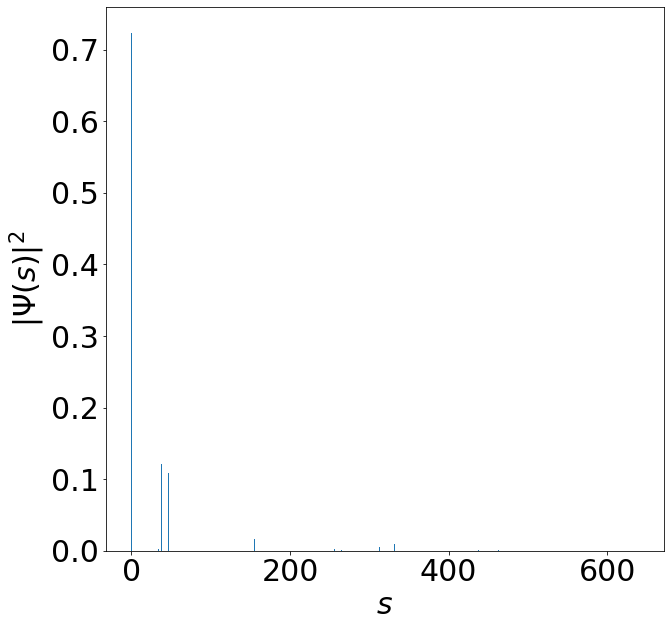

In [7]:
overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.figure(figsize=(10,10))
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.xlabel(r'$s$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

#### Quantum Optimal Control with the simpler Hamiltonian

I want to diagonalize the $J^2$ operator in the subshell

332it [00:01, 212.47it/s]


J^2= [-7.88152731] 



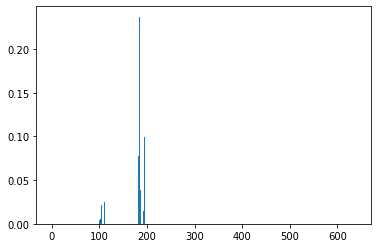

(640,)
()
2.3722813232690143
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
()
2.3722813232690143
[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
()
4.216990566028302
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
()
3.8874821936960613
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]
()
3.274917217635375
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
()
3.6533119314590374
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
()
4.216990566028301
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
()
3.7720018726587643
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
()
4.109772228646442
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
()
3.772001872658765
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0]
()
4.109772228646443
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
()
3.274917217635374
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
()
3.6533119314590365
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
()
3.1400549446402577
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0

In [8]:
j2_matrix=J2pshell.twobody_dictionary
lowest_j=[0,1,2,3,4,6,7,8,9,10]

restricted_j2_matrix={}
for key,value in j2_matrix.items():
    
    a,b,c,d=key
    if a in lowest_j and b in lowest_j and c in lowest_j and d in lowest_j:
        restricted_j2_matrix[(a,b,c,d)]=value


j2=1.5*(1.5+1)
diagonal_restricted_j=np.zeros(size_a+size_b)
diagonal_restricted_j[lowest_j]=j2

J2_restricted=FermiHubbardHamiltonian(size_a=size_a,size_b=size_a,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
        
J2_restricted.get_twobody_interaction(restricted_j2_matrix)
J2_restricted.get_external_potential(external_potential=diagonal_restricted_j)
J2_restricted.get_hamiltonian()
value,psi_initial=J2_restricted.get_spectrum(n_states=1)
prob=psi_initial[:,0].conj()*psi_initial[:,0]
print('J^2=',value,'\n')
plt.bar(np.arange(psi_initial.shape[0]),prob)
plt.show()
print(prob.shape)
for i,b in enumerate(J2_restricted.basis):
    psi_new=np.zeros_like(psi_initial[:,0])
    psi_new[i]=1
    print(J2pshell.j_value(psi_new))
    if prob[i] !=0:
        print(b)


Initialize the initial Hamiltonian

In [13]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1

occupancy=np.zeros_like(energies)

occupancy[6]=1
occupancy[7]=1
occupancy[6+size_a]=1
occupancy[7+size_a]=1

print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*occupancy#min_b OCCUPANCY IS JUST TEMPORARY
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

e0,psis=InitialHamiltonian.get_spectrum(n_states=1)
psi_configuration=psis[:,0]
print('j value=',J2pshell.j_value(psi=psi_configuration))
print('std j value=', psi_configuration.conjugate().dot((J2pshell.hamiltonian @ J2pshell.hamiltonian).dot(psi_configuration)) )
print(np.abs(PPoperator.hamiltonian @ J2pshell.hamiltonian - J2pshell.hamiltonian @ PPoperator.hamiltonian).mean())
print(np.abs(MeanFieldHamiltonian.hamiltonian @ J2pshell.hamiltonian - J2pshell.hamiltonian @ MeanFieldHamiltonian.hamiltonian).mean())
print(np.abs(QQoperator.hamiltonian @ J2pshell.hamiltonian - J2pshell.hamiltonian @ QQoperator.hamiltonian).mean())
print(np.abs(LocalQQoperator.hamiltonian @ J2pshell.hamiltonian - J2pshell.hamiltonian @ LocalQQoperator.hamiltonian).mean())
print(np.abs(InitialHamiltonian.hamiltonian @ J2pshell.hamiltonian - J2pshell.hamiltonian @ InitialHamiltonian.hamiltonian).mean())


initial state= [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
idx= 26
min energy= -30.21714603174604
()
j value= 4.440892098500626e-16
std j value= 1.0020939507098206e-28
1.0129891900227551e-16
2.7389131221616977e-33
4.99188325530328e-16
1.7357398673652476e-16
0.0


In [ ]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=PPoperator.hamiltonian,second_target_hamiltonian=QQoperator.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,mean_field_target_hamiltonain=MeanFieldHamiltonian.hamiltonian,tf=tf,nsteps=nsteps,number_of_parameters=number_of_parameters,type='F-CRAB',seed=42,reference_hamiltonian=TargetHamiltonian.hamiltonian,mode='F-CRAB',random=False,J2operator=J2pshell)
print(model.parameters.shape)


bounds=[(0,20) for i in range(model.parameters.shape[0])]

local_search_options = {
    'method': 'L-BFGS-B',  # Specify L-BFGS-B as the local search method
    'bounds': bounds       # Pass the bounds
}

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
)

#res=dual_annealing(model.forward,bounds,callback=model.callback,maxiter=1000,maxfun=1000,local_search_options=local_search_options,no_local_search=True)

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)

(30,)
()
j_value of psi= (8.326672684688674e-15-4.827171278262477e-17j)
(-19.886549801648414-2.220446049250313e-16j)
()
j_value of psi= (9.43689570931383e-15-6.869750156051247e-18j)
(-24.81772017884089+8.881784197001252e-16j)
()
j_value of psi= (8.881784197001252e-15-2.0231496050607416e-17j)
(-26.46976881440147-3.552713678800501e-15j)
()
j_value of psi= (1.1324274851176597e-14-1.0664916018919761e-16j)
(-28.92663723218078-8.881784197001252e-16j)
()
j_value of psi= (1.176836406102666e-14-1.2033141127898274e-16j)
(-29.07286681035715-1.7763568394002505e-15j)
()
j_value of psi= (1.1657341758564144e-14+4.337416698773263e-18j)
(-31.389452257796638-1.7763568394002505e-15j)
()
j_value of psi= (1.1435297153639112e-14-1.0221530137078821e-16j)
(-31.535781110503855-1.7763568394002505e-15j)
()
j_value of psi= (1.099120794378905e-14-1.1858498119964295e-16j)
(-32.00473866822265+1.7763568394002505e-15j)
()
j_value of psi= (1.0769163338864018e-14+3.872541625260988e-17j)
(-32.580168250477556+0j)
()
j_val

#### Analysis of the Optimization

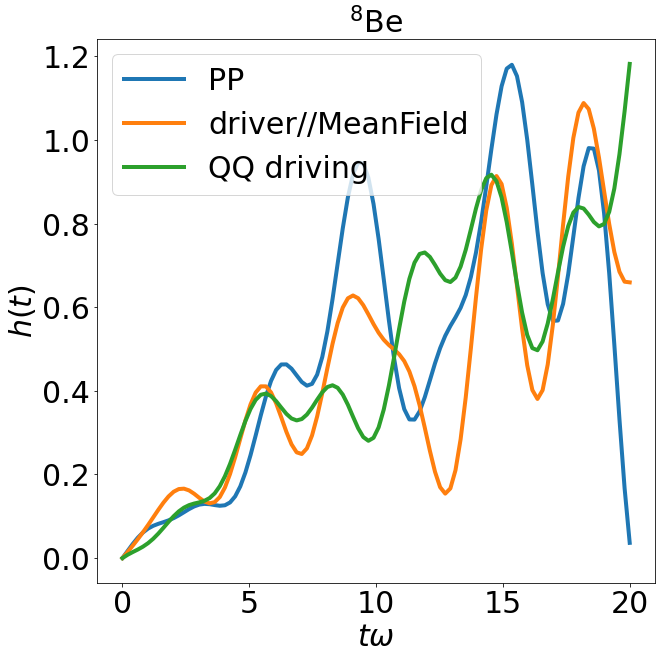

(0.8484066320968715+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


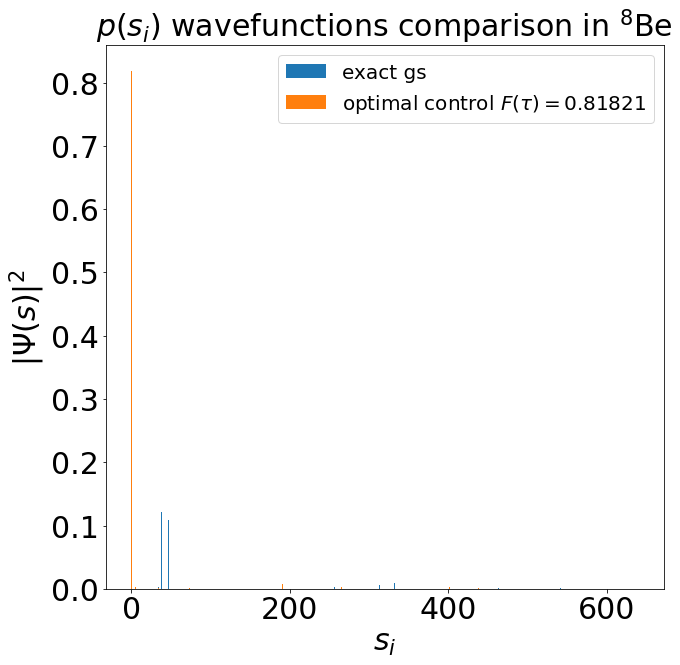

In [83]:
hd,ht,ht2=model.get_driving()
plt.figure(figsize=(10,10))
plt.title(title,fontsize=30)

plt.plot(model.time,ht,label='PP',linewidth=4)
plt.plot(model.time,hd,label='driver//MeanField',linewidth=4)
plt.plot(model.time,ht2,label='QQ driving',linewidth=4)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.ylabel(r'$h(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()


overlap_optimization=np.einsum('i,ia->a',model.psi.conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',model.psi.conjugate(),eigenstates))


print((psi0[:,0].conjugate().dot(model.psi)).conjugate()*psi0[:,0].conjugate().dot(model.psi))
plt.figure(figsize=(10,10))
plt.title(r'$p(s_i)$ wavefunctions comparison in '+title,fontsize=30)
plt.bar(np.arange(overlap.shape[0]),overlap,label='exact gs')
plt.bar(np.arange(overlap.shape[0])+0.5,overlap_optimization,label=r'optimal control $F(\tau)=$'+f'{overlap_optimization[0].real:.5f}')
plt.xlabel(r'$s_i$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.legend(fontsize=20)
plt.show()


#### Analysis of the results

In [ ]:
hamiltonian_interpolate=(1-model.time/model.tf)